In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import root_mean_squared_error

In [31]:

print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [63]:
ticker = 'AAPL' 
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [64]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716064,72.776591,71.466805,71.721011,135480400
2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800
2020-01-06,72.582893,72.621631,70.876060,71.127851,118387200
2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000
2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200
...,...,...,...,...,...
2025-04-30,212.500000,213.580002,206.669998,209.300003,52286500
2025-05-01,213.320007,214.559998,208.899994,209.080002,57365700


<Axes: xlabel='Date'>

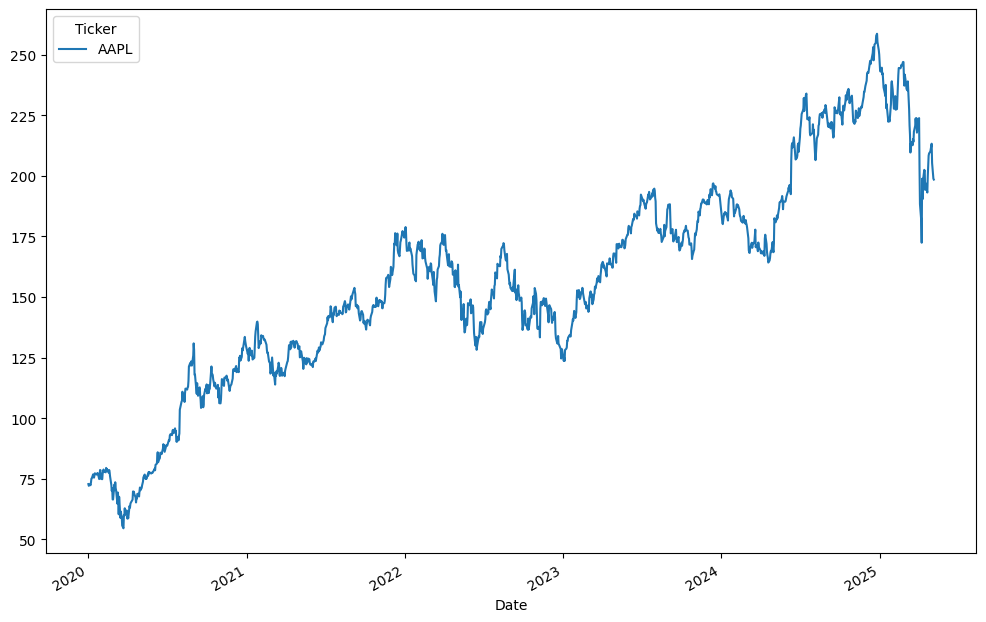

In [65]:
df.Close.plot(figsize = (12, 8))

In [66]:
scaler  = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [67]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.890430
2020-01-03,-1.906354
2020-01-06,-1.893430
2020-01-07,-1.901118
2020-01-08,-1.874943
...,...
2025-04-30,1.258088
2025-05-01,1.276558
2025-05-02,1.097040


In [68]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data  = np.array(data)
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size:, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size:, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)




In [69]:
class PredictionModel(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True, dropout = 0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1,])
        return out
    

In [70]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1).to(device)

In [71]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [72]:
num_epochs = 200
for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i%25 == 0:
        print(i, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6490454077720642
25 0.013618969358503819
50 0.008166398853063583
75 0.007515317294746637
100 0.0070210653357207775
125 0.006236198823899031
150 0.006376203615218401
175 0.0058493721298873425


In [73]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [74]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])


In [75]:
train_rmse

3.3030874729156494

In [76]:
test_rmse

15.276017189025879

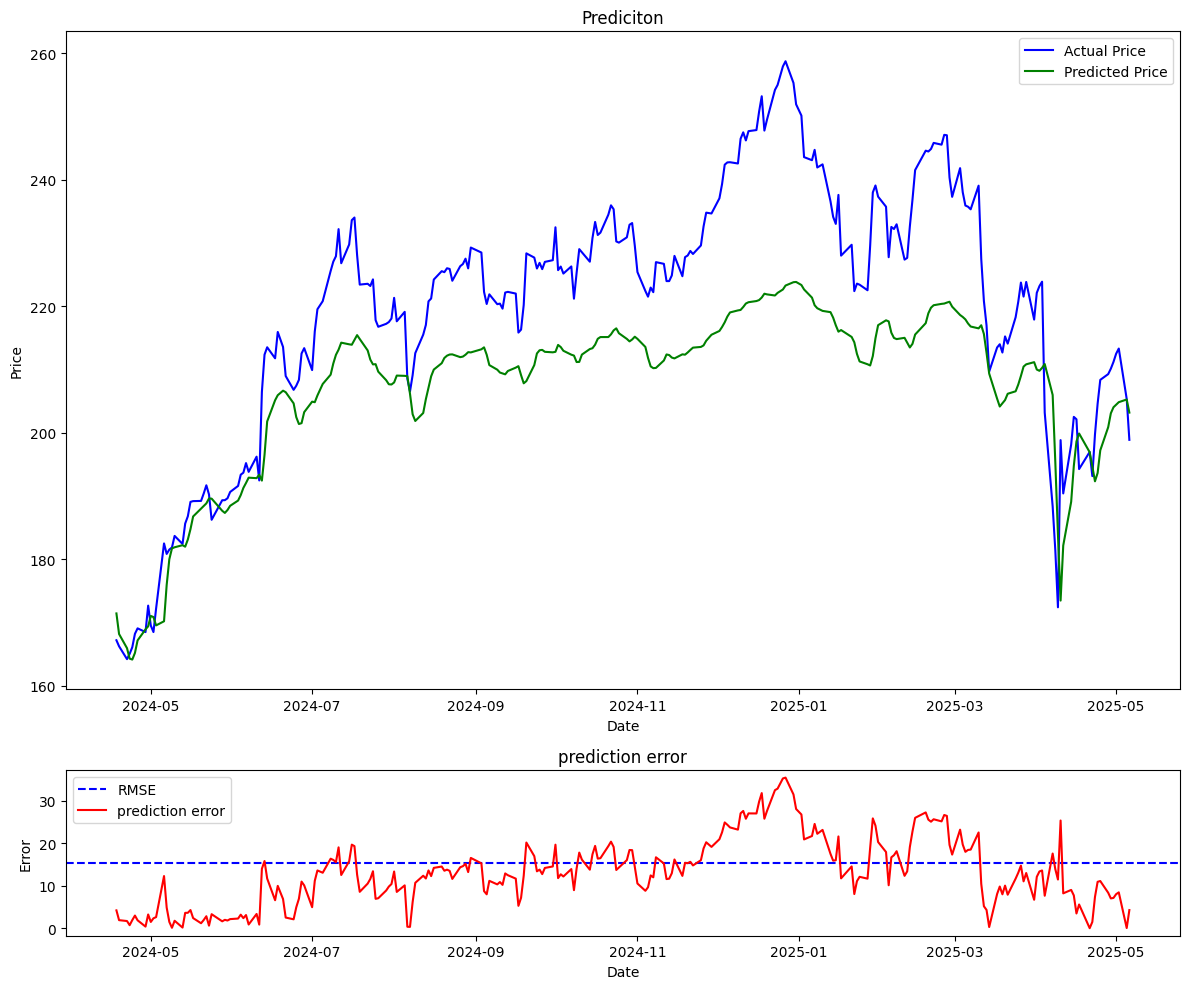

In [79]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = "Predicted Price")
ax1.legend()
plt.title("Prediciton")
plt.xlabel("Date")
plt.ylabel("Price")

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = "blue", linestyle = "--", label = "RMSE")
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = "prediction error")
ax2.legend()
plt.title('prediction error')
plt.xlabel("Date")
plt.ylabel("Error")

plt.tight_layout()
plt.show()